<a href="https://colab.research.google.com/github/Melo95/ML_course_Pavia_23/blob/v2/ML_course_project_Image_reconstruction_with_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML PhD Course - Final project - Carmelo Grova

This notebook describes a possible application of Machine Learning instead of classical Phase Retrieval algoritms (1. Fienup, J. R. Phase retrieval algorithms: a comparison. Appl. Opt. 21, 2758 (1982).
) used for image reconstruction from far field diffraction patterns.


The goal of traditional iterative algorithms is to reconstruct, from the far field diffraction pattern, the exit surface wave arising from the interaction of a complex probe - a beam with amplitude and phase -  and a complex object. For realistic samples the amplitude may represent chemical composition and the phase is correlated to topographic information. The exit surface wave consist in pointwise multiplication of probe and object and it can be recovered by solving the phase problem applying constraints in the real a fourier space thanks to a priori knowledge.

This project aims to achieve the at least the same result of the classical Hybrid Input-Output algorithm (HIO) and goes forward in trying to reconstruct the amplitude and phase of the object with no a priori assumptions.
For this purpose I used the MNIST and fMNIST datasets in Keras which have the substantial advantage of containing exactly the same number of images with the same normalization conditions and same number of pixels. The size of the dataset allows to have enough training, validation and test data.
An autoencoder composed with a single encoder and different decoders is used in order to have independent and parallel reconstruction of Amplitude and Phase of the object.

In order to achieve a satisfying results in terms of image reconstruction, I explored different values of the following parameters of the Network:
- Number of layers
- Number of filters
- Kernel size
- Strides
- Activation function
- Batch normalization
- Maxpooling

And hyperparameters:
- Loss functions
- Batch size
- Learning rate
- Number of epochs

The results are typically very good for the recontruction of the object
amplitude (numbers from MNIST dataset) but struggle with the identification of the phase (clothers from fMNIST dataset). For the amplitude reconstruction an autoencoder with 2 layers with 32 filter proved to be sufficient. The complexity of the network is mainly increased for reaching good results on the phase.

Author: Carmelo Grova, Università degli Studi di Pavia, Dept. of Physics
email address: carmelo.grova01@universitadipavia.it
July 2023


# Import libraries



In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow.keras.models import Model

## Import train and test data from MNIST and fMNIST datasets

In [2]:
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets however for our purpose the labels (y_...) are not important!
(x_train_MNIST, y_train_MNIST), (x_test_MNIST, y_test_MNIST) = keras.datasets.mnist.load_data()
(x_train_fMNIST, y_train_fMNIST), (x_test_fMNIST, y_test_fMNIST) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train_MNIST = x_train_MNIST.astype("float32") / 255
x_test_MNIST = x_test_MNIST.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train_MNIST = np.expand_dims(x_train_MNIST, -1)
x_test_MNIST = np.expand_dims(x_test_MNIST, -1)
print("x_train_MNIST shape:", x_train_MNIST.shape)
print(x_train_MNIST.shape[0], "train samples")
print(x_test_MNIST.shape[0], "test samples")

# Scale images to the [0, 1] range
x_train_fMNIST = x_train_fMNIST.astype("float32") / 255
x_test_fMNIST = x_test_fMNIST.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train_fMNIST = np.expand_dims(x_train_fMNIST, -1)
x_test_fMNIST = np.expand_dims(x_test_fMNIST, -1)
print("x_train_fMNIST shape:", x_train_fMNIST.shape)
print(x_train_fMNIST.shape[0], "train samples")
print(x_test_fMNIST.shape[0], "test samples")

x_train_MNIST shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
x_train_fMNIST shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Create a circular mask to constraint the probe in a limited area

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask

## Create a complex gaussian probe

In [4]:
# create mask
x = np.arange(-x_train_MNIST.shape[1]/2,x_train_MNIST.shape[1]/2,1)
y = np.arange(-x_train_MNIST.shape[1]/2,x_train_MNIST.shape[1]/2,1)

X,Y = np.meshgrid(x,y)


A = 1
sigma = 10
prb_gaussian = A* np.exp(-(X**2 + Y**2)/2/sigma**2) #if I put a phase factor here, the result of the absolute value of the diffraction pattern is a complex tensor, I have not solved this issue so the beam has flat phase profile

mask = create_circular_mask(prb_gaussian.shape[0],prb_gaussian.shape[1], center = None, radius = 14)

complex_mask = mask*np.exp(1j*mask)
complex_prb = prb_gaussian*complex_mask

complex_prb_amplitude = np.abs(complex_prb)
complex_prb_phase = np.angle(complex_prb)
complex_prb_phase[complex_prb_amplitude == 0] = 0

updated_complex_prb = complex_prb_amplitude*np.exp(1j*complex_prb_phase)


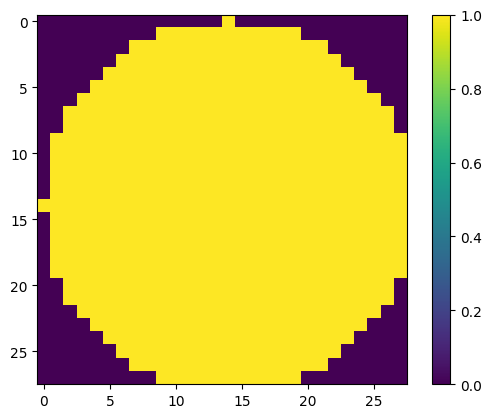

In [5]:
plt.imshow(np.angle(updated_complex_prb))
plt.colorbar()

In [6]:
# give the tensor of the probe the same structure as the images in the Keras datasets
updated_complex_prb_tensor = tf.convert_to_tensor(updated_complex_prb,dtype="complex64")
updated_complex_prb_tensor_tiled = tf.expand_dims(tf.tile(tf.expand_dims(updated_complex_prb, axis=0), [60000, 1, 1]),axis = 3)
updated_complex_prb_tensor_tiled.shape

TensorShape([60000, 28, 28, 1])

## Create the exit surface wave and project it in order to get far field diffraction pattern

In [7]:
# exit surface wave
x_train_complex = (x_train_MNIST+0.5)*np.exp(1j*x_train_fMNIST) #remember that when amplitude is 0 then the phase is assumed to be 0 as well so I add 0.5 in order to distincty see the piece of clothing used as phase

exit_surface_wave = x_train_complex*updated_complex_prb_tensor_tiled

exit_surface_wave_amplitude = np.abs(exit_surface_wave)
exit_surface_wave_phase = np.angle(exit_surface_wave)
exit_surface_wave_phase[exit_surface_wave_amplitude == 0] = 0

updated_exit_surface_wave = exit_surface_wave_amplitude*np.exp(1j*exit_surface_wave_phase)

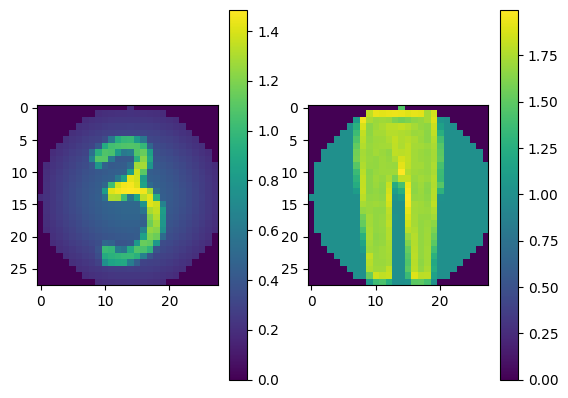

In [8]:
fig, ax = plt.subplots(1,2)
amp = ax[0].imshow(tf.math.abs(updated_exit_surface_wave[98,:,:,:]))
phase = ax[1].imshow(tf.math.angle(updated_exit_surface_wave[98,:,:,:]))
plt.colorbar(amp)
plt.colorbar(phase)


In [9]:
# lets squeeze the dataset in order to be digested by the fft fuction below
exit_surface_wave_squeezed = tf.squeeze(updated_exit_surface_wave)


# 2D fft + centering the zero frenquecy component + taking the absolute value, which is the only information we have in real experiment since detectors are intensity based
exit_surface_wave_squeezed_fft = tf.signal.fft2d(tf.cast(exit_surface_wave_squeezed,tf.complex64))
diffraction_pattern = np.abs(tf.signal.fftshift(exit_surface_wave_squeezed_fft,axes=(-2,-1)))

# unsqueeze to go back to the 4D tensor shape which will be used for the model
diffraction_pattern_unsqueezed = tf.expand_dims(diffraction_pattern,-1)
diffraction_pattern_unsqueezed.shape

TensorShape([60000, 28, 28, 1])

## Create the autoencoder

In [10]:
inputs = keras.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(64, (3, 3), padding="same")(inputs)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(256, (3, 3), padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.BatchNormalization()(x)

# Decoder1
x1 = layers.UpSampling2D(size=(2, 2))(x)
x1 = layers.Conv2D(256, (3, 3), padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.2)(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.UpSampling2D(size=(2, 2))(x)
x1 = layers.Conv2D(128, (3, 3), padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.2)(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.UpSampling2D(size=(2, 2))(x1)
x1 = layers.Conv2D(64, (3, 3), padding="same")(x1)
x1 = layers.LeakyReLU(alpha=0.2)(x1)
x1 = layers.BatchNormalization()(x1)
output1 = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x1)

# Decoder2
x2 = layers.UpSampling2D(size=(2, 2))(x)
x2 = layers.Conv2D(256, (3, 3), padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.2)(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.UpSampling2D(size=(2, 2))(x)
x2 = layers.Conv2D(128, (3, 3), padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.2)(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.UpSampling2D(size=(2, 2))(x2)
x2 = layers.Conv2D(64, (3, 3), padding="same")(x2)
x2 = layers.LeakyReLU(alpha=0.2)(x2)
x2 = layers.BatchNormalization()(x2)
output2 = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x2)

model_sequential = keras.Model(inputs=inputs, outputs=[output1, output2])
model_sequential.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   640         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 28, 28, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['leaky_re_lu[0][0]']            
 alization)                                                                                   

## Train the model and change hyperparameters

Epoch 1/4
844/844 [==============================] - 33s 33ms/step - loss: 0.2435 - conv2d_6_loss: 0.1887 - conv2d_10_loss: 0.0548 - val_loss: 0.2462 - val_conv2d_6_loss: 0.1858 - val_conv2d_10_loss: 0.0605
Epoch 2/4
844/844 [==============================] - 27s 32ms/step - loss: 0.2053 - conv2d_6_loss: 0.1599 - conv2d_10_loss: 0.0454 - val_loss: 0.2067 - val_conv2d_6_loss: 0.1625 - val_conv2d_10_loss: 0.0442
Epoch 3/4
844/844 [==============================] - 27s 32ms/step - loss: 0.1937 - conv2d_6_loss: 0.1510 - conv2d_10_loss: 0.0427 - val_loss: 0.1969 - val_conv2d_6_loss: 0.1548 - val_conv2d_10_loss: 0.0421
Epoch 4/4
844/844 [==============================] - 27s 32ms/step - loss: 0.1866 - conv2d_6_loss: 0.1458 - conv2d_10_loss: 0.0408 - val_loss: 0.1927 - val_conv2d_6_loss: 0.1499 - val_conv2d_10_loss: 0.0428


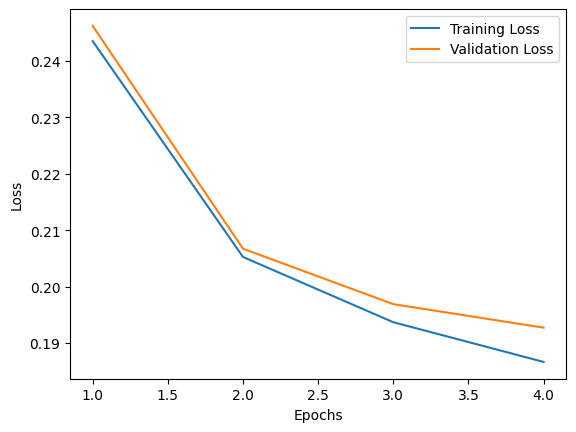

In [16]:
batch_size = 64 #64 works well
epochs = 20

model_sequential.compile(loss=['binary_crossentropy','mean_squared_error'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
history = model_sequential.fit(diffraction_pattern_unsqueezed, [x_train_MNIST, x_train_fMNIST], batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Access the training loss and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure()
plt.plot(range(1, epochs+1), training_loss, label='Training Loss')
plt.plot(range(1, epochs+1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing the network

In [17]:
x_test_complex = (x_test_MNIST+0.5)*np.exp(1j*x_test_fMNIST) #remember that when amplitude is 0 then the phase is assumed to be 0 as well so I add 0.5 in order to distincty see the piece of clothing used as phase

exit_surface_wave_test = x_test_complex*updated_complex_prb_tensor_tiled[:10000,:,:,:]

exit_surface_wave_amplitude_test = np.abs(exit_surface_wave_test)
exit_surface_wave_phase_test = np.angle(exit_surface_wave_test)
exit_surface_wave_phase_test[exit_surface_wave_amplitude_test == 0] = 0

updated_exit_surface_wave_test = exit_surface_wave_amplitude_test*np.exp(1j*exit_surface_wave_phase_test)

# lets squeeze the dataset in order to be digested by the fft fuction below
exit_surface_wave_squeezed_test = tf.squeeze(updated_exit_surface_wave_test)


# 2D fft + centering the zero frenquecy component + taking the absolute value, which is the only information we have in real experiment since detectors are intensity based
exit_surface_wave_squeezed_fft_test = tf.signal.fft2d(tf.cast(exit_surface_wave_squeezed_test,tf.complex64))
diffraction_pattern_test = np.abs(tf.signal.fftshift(exit_surface_wave_squeezed_fft_test,axes=(-2,-1)))

# unsqueeze to go back to the 4D tensor shape which will be used for the model
diffraction_pattern_unsqueezed_test = tf.expand_dims(diffraction_pattern_test,-1)
diffraction_pattern_unsqueezed_test.shape

TensorShape([10000, 28, 28, 1])

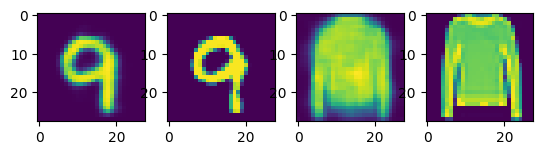

In [21]:
out_seq = model_sequential(diffraction_pattern_unsqueezed_test[1:100])
output_ampl = out_seq[0]
output_phase = out_seq[1]
# out_seq.shape

test_sample = 98

fig, ax = plt.subplots(1,4)
ax[0].imshow(output_ampl[test_sample])
ax[1].imshow(x_test_MNIST[1:100][test_sample])
ax[2].imshow(output_phase[test_sample])
ax[3].imshow(x_test_fMNIST[1:100][test_sample])
